In [ ]:
# STEP 2: Create state-space model
# Using the matrix and vector formulation described in notebook 4.2, rewrite the equations for the four state model in state-space form. 

In [98]:
# Use the parameter values from Step 1 to numerically evaluate matrices  𝐴 ,  𝐵𝑢 ,  𝐵𝑑  and  𝑑 . 

P1 =  0.041              # power input when the system is turned
CpH =  8.237             # heat capacity of the heater (J/deg C)
CpS = 1.636              # heat capacity of the sensor (J/deg C)
Ua =  0.0408             # heat transfer coefficient from heater to environment
Ub = 0.0953              # heat transfer coefficient from heater to sensor
Uc = 0.0294              # heat transfer coefficient from heater to sensor
Tamb = 22                # ambient room temperature

# Set parameter values
alpha = 0.00016        # watts / (units P1 * percent U1)
P1=200
P2=100

# state space model
A = np.array([ [-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0],
        [Ub/CpS, -Ub/CpS, 0, 0],
        [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
        [0, 0, Ub/CpS, -Ub/CpS]])

print('A =',A)


Bu = np.array([ [alpha*P1/CpH, 0],
        [0, 0],[0, alpha*P2/CpH],[0, 0]
    ])

print('Bu =',Bu)


Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])
    
print('Bd = ',Bd)

C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

d = np.array([Tamb])

print('d=',d)


A = [[-0.02009227  0.01156975  0.00356926  0.        ]
 [ 0.05825183 -0.05825183  0.          0.        ]
 [ 0.00356926  0.         -0.02009227  0.01156975]
 [ 0.          0.          0.05825183 -0.05825183]]
Bu = [[0.00388491 0.        ]
 [0.         0.        ]
 [0.         0.00194245]
 [0.         0.        ]]
Bd =  [[0.00495326]
 [0.        ]
 [0.00495326]
 [0.        ]]
d= [22]


In [99]:
# Compute the eigenvalues (they should all be negative real numbers) of  𝐴  and report the negative inverse of the eigenvalues as time constants.
eigenvalues, _ = np.linalg.eig(A)
print('The eigenvalues of A are:',np.real(eigenvalues))
print('Time constants of A are:', -1.0/np.real(eigenvalues), 'seconds')

The eigenvalues of A are: [-0.00408152 -0.00976243 -0.07215093 -0.07069332]
Time constants of A are: [245.00652672 102.43351255  13.85983503  14.14560895] seconds


In [100]:
# STEP 3: Implement a state estimate utilizing measurements T1 and T2, and inputs Q1 and Q2, to estimate the state.

In [101]:
# Implement a state estimate utilizing measurements T1 and T2, and inputs Q1 and Q2, to estimate the state. As an initial choice for matrix  𝐿  use

L = np.array([[0.4,0], [0.2,0],[0,0.4], [0,0.2]])
print(L)

eigenvalues_observer, _ = np.linalg.eig(A - np.dot(L, C))
print('Time constants of A - LC are:', -1.0/np.real(eigenvalues_observer), 'seconds')

[[0.4 0. ]
 [0.2 0. ]
 [0.  0.4]
 [0.  0.2]]
Time constants of A - LC are: [7.27868681 7.27868681 7.09437819 7.09437819] seconds


In [102]:
def tclab_observer(L):
    # initialize variables
    t_now = 0                          # current time
    x_now = np.array([Tamb, Tamb,Tamb,Tamb])     # approximated as Tamb
    d = [Tamb]                         # estimate of unmeasured disturbances (Tamb for both heaters)
    
    while True:
        # yield current state, get MV for next period
        t_next, Q1, Q2, T_measured_1, T_measured_2 = yield x_now
        
        # model prediction
        u = [Q1, Q2]
        d = [Tamb]
        x_predict = x_now + (t_next - t_now)*(np.dot(A, x_now) + np.dot(Bu, u) + np.dot(Bd, d))
        
        # measurement correction
        y = np.array([T_measured_1,T_measured_2])
        x_correct = x_predict - (t_next - t_now)*np.dot(L, np.dot(C, x_predict) - y)
        
        # update time and state
        t_now = t_next
        x_now = x_correct

In [103]:
# STEP 4 -
# Using constant setpoints of 45 and 40 degrees, respectively, for temperatures  𝑇1  and  𝑇2 . 
# At time t = 300, have the setpoints switch to 40 and 45 degrees, respectiviely. 
# Show control performance over total of 600 seconds when using sensor measurements for relay control. 
# Replace the sensor measurements with observer estimates for heater temperatures  𝑇𝐻,1  and  𝑇𝐻,2  and repeat the test. 
# What do you observe?

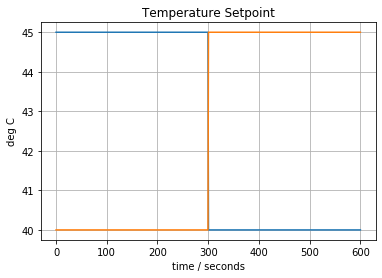

In [104]:
# Create setpoint function

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Temperature Setpoints
def SP1(t):
    tp1 = [  0,  300,  300,  500]
    Tp1 = [ 45,   45,   40,   40]

    return np.interp(t, tp1, Tp1)

def SP2(t):
    tp2 = [  0,  300,  300,  500]
    Tp2 = [ 40,   40,   45,   45]

    return np.interp(t, tp2, Tp2)

t = np.linspace(0, 600, 600)
fig, ax = plt.subplots(1, 1)
ax.plot(t, SP1(t))
ax.plot(t, SP2(t))
ax.set_title('Temperature Setpoint')
ax.set_xlabel('time / seconds')
ax.set_ylabel('deg C')
ax.grid(True)

In [105]:
# Set Up Relay Control
def relay(MV_min, MV_max):
    MV = MV_min
    while True:
        SP, PV = yield MV
        MV = MV_max if PV < SP else MV_min

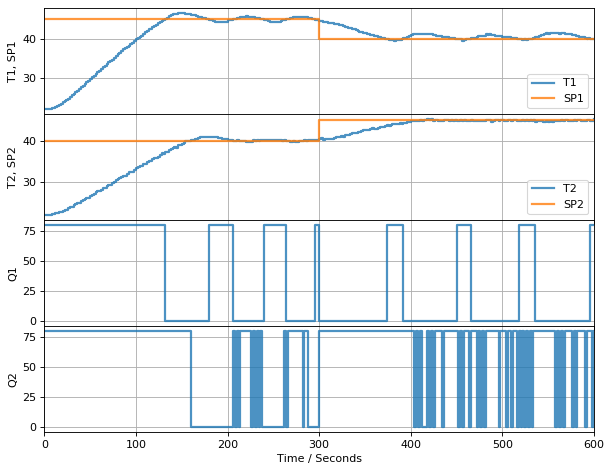

TCLab disconnected successfully.


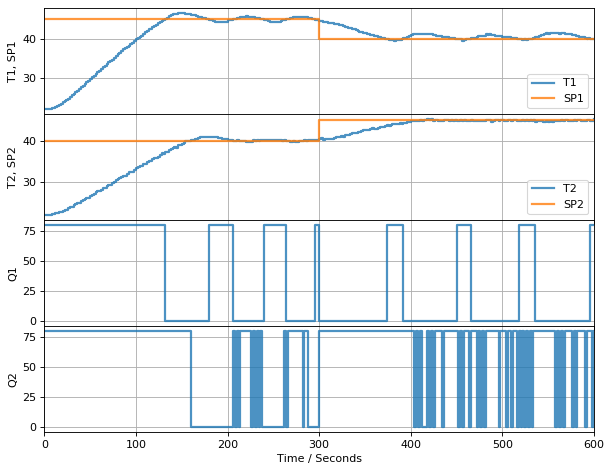

In [107]:
# Show control performance over total of 600 seconds when using sensor measurements for relay control.

from tclab import setup, clock, Historian, Plotter

# run time
t_final = 600
t_step = 2

# create a controller instance
controller_1 = relay(MV_min=0, MV_max=80)
controller_2 = relay(MV_min=0, MV_max=80)
U1 = next(controller_1)
U2 = next(controller_2)


# execute the event loop
TCLab = setup(connected=True)
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1(t)),('SP2', lambda: SP2(t)), ('T1', lambda: lab.T1), ('T2', lambda: lab.T2), ('Q1', lab.Q1), ('Q2', lab.Q2), 
    ])
    p = Plotter(h, t_final, layout=[['T1', 'SP1'],['T2','SP2'], ['Q1'],['Q2']])
    for t in clock(t_final, t_step):
        T1 = lab.T1
        T2 = lab.T2
        U1 = controller_1.send([SP1(t), T1]) 
        U2 = controller_2.send([SP2(t),T2])
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t) 

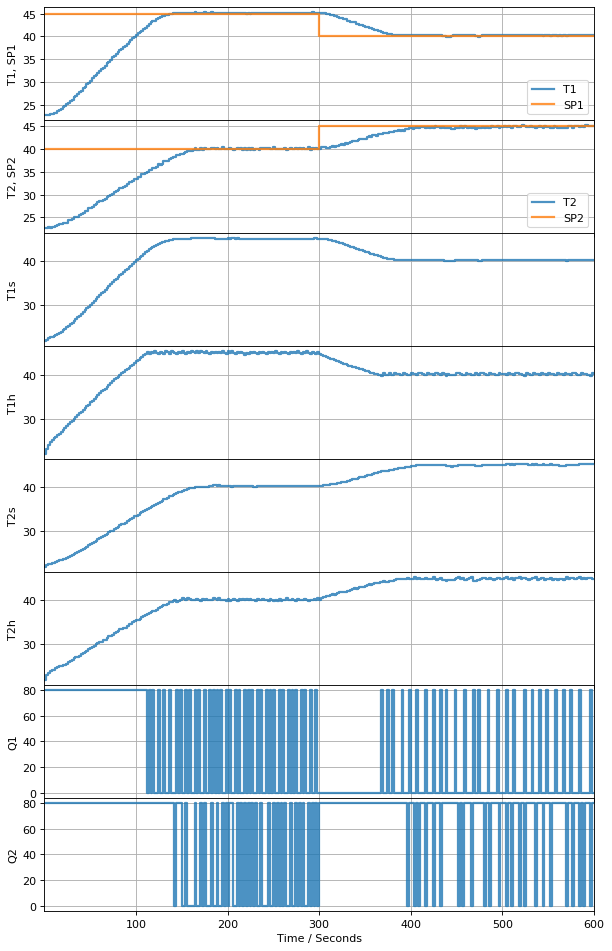

TCLab disconnected successfully.


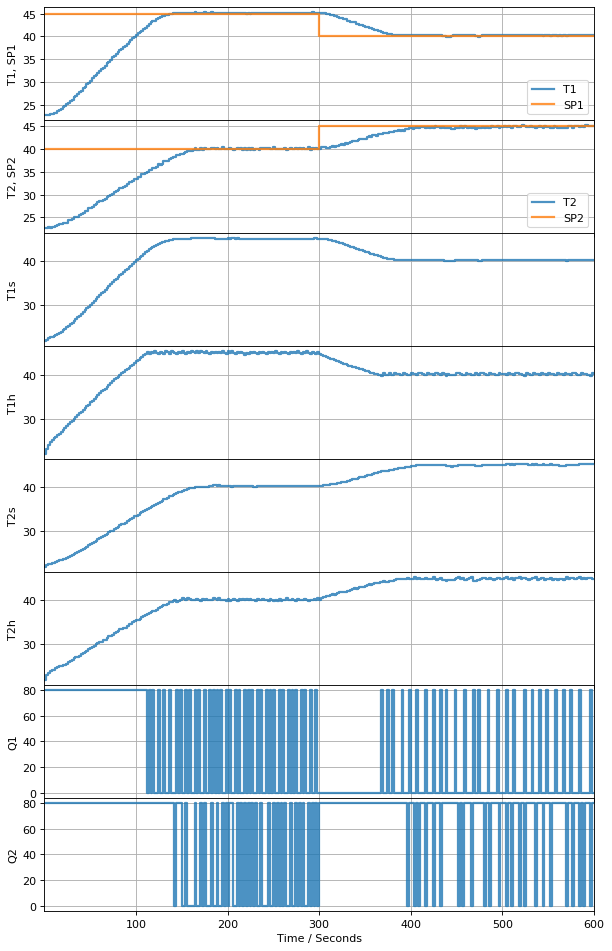

In [109]:
# Replace the sensor measurements with observer estimates for heater temperatures  𝑇𝐻,1  and  𝑇𝐻,2  and repeat the test. 
# What do you observe?

t_final = 600        # run time
t_step = 2

# create a controller instance
controller_1 = relay(0,80)
controller_2 = relay(0,80)
U1 = next(controller_1)
U2 = next(controller_2)

# create estimator instance
L = np.array([[0.4,0], [0.2,0],[0,0.4], [0,0.2]])
observer = tclab_observer(L)
T1h, T1s, T2h, T2s = next(observer)

# execute the event loop
TCLab = setup(connected=True)
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1(t)),('SP2', lambda: SP2(t)), ('T1', lambda: lab.T1), ('T2', lambda: lab.T2), ('Q1', lab.Q1), ('Q2', lab.Q2), 
                   ('T1h', lambda: T1h), ('T1s', lambda: T1s),('T2h', lambda: T2h), ('T2s', lambda: T2s)])
    p = Plotter(h, t_final, layout=[['T1', 'SP1'],['T2','SP2'], ['T1s'], ['T1h'], ['T2s'], ['T2h'], ['Q1'],['Q2']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        T1h, T1s, T2h, T2s = observer.send([t, U1, U2, T1, T2])
        U1 = controller_1.send([SP1(t), T1h]) 
        U2 = controller_2.send([SP2(t),T2h])
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

Text(240.01, 52.14937717168061, 'Predicted Sensor Temperature Ts1')

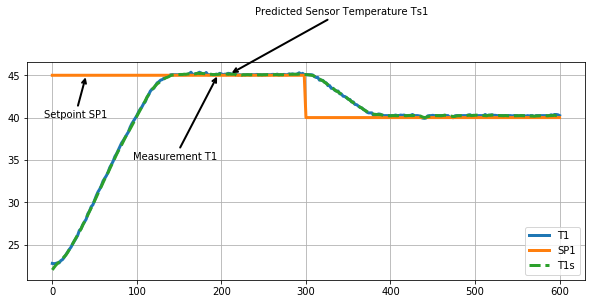

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(h.logdict["Time"], h.logdict["T1"], label="T1", lw=3)
ax.plot(h.logdict["Time"], h.logdict["SP1"], label="SP1", lw=3)
ax.plot(h.logdict["Time"], h.logdict["T1s"], "--", label="T1s", lw=3)
ax.legend()
ax.grid(True)

xy = np.array((h.logdict["Time"][98], h.logdict["T1"][98]))
ax.annotate('Measurement T1', xy=xy, xytext=xy + np.array([-100, -10]),
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

xy = np.array((h.logdict["Time"][20], h.logdict["SP1"][20]))
ax.annotate('Setpoint SP1', xy=xy, xytext=xy + np.array([-50, -5]), 
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

xy = np.array((h.logdict["Time"][105], h.logdict["T1s"][105]))
ax.annotate('Predicted Sensor Temperature Ts1', xy=xy, xytext=xy + np.array([30, 7]), 
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

Text(240.01, 47.03301102005232, 'Predicted Sensor Temperature T2s')

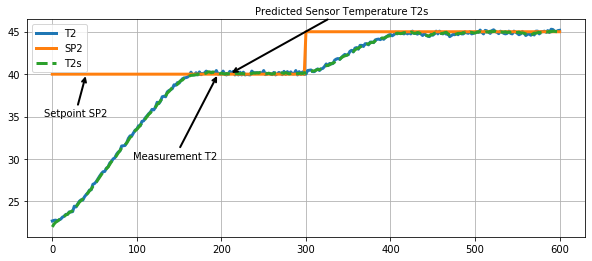

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(h.logdict["Time"], h.logdict["T2"], label="T2", lw=3)
ax.plot(h.logdict["Time"], h.logdict["SP2"], label="SP2", lw=3)
ax.plot(h.logdict["Time"], h.logdict["T2s"], "--", label="T2s", lw=3)
ax.legend()
ax.grid(True)

xy = np.array((h.logdict["Time"][98], h.logdict["T2"][98]))
ax.annotate('Measurement T2', xy=xy, xytext=xy + np.array([-100, -10]),
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

xy = np.array((h.logdict["Time"][20], h.logdict["SP2"][20]))
ax.annotate('Setpoint SP2', xy=xy, xytext=xy + np.array([-50, -5]), 
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

xy = np.array((h.logdict["Time"][105], h.logdict["T2s"][105]))
ax.annotate('Predicted Sensor Temperature T2s', xy=xy, xytext=xy + np.array([30, 7]), 
            arrowprops = dict(arrowstyle="->", facecolor ='green',lw=2))

In [ ]:
# What do you observe?

# When the observer function is used to estimate the states, the heater temperatures are able to steadily track the setpoints and match sensor temperatures. 
# There is also less oscillation of the measured temperatures and faster transitions when there are setpoint changes than in simple relay control. 
# From this experiment, it can be seen that the observer does a better job of matching the model response to the 
# measured temperatures of the sensors and it can successfully control the estimated heater temperatures.